# 02_process_embedding

## 1. Цель ноутбука

- посчитать статитстику по словам
- посчитать TF-IDF
- взять готовый W2V и посчитать итоговый ембеддинг для всего предложения
- возможно, попробовать файнтьюнить W2V
- попробовать D2V
- попробовать модель с HuggingFace ai-forever/sbert_large_nlu_ru

## 2. Imports

In [1]:
from pathlib import Path
import logging
import pandas as pd
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
from typing import List

## 3. Initialization

In [2]:
pd.set_option("display.max_colwidth", None)

plt.style.use("classic")

In [3]:
PROJECT_NAME = "finam_text_classification"

# Get the current working directory
current_dir = Path.cwd()


# Traverse up to find "finam_text_classification" folder
project_root = current_dir
while project_root.name != PROJECT_NAME:
    if project_root.parent == project_root:  # Reached the filesystem root
        raise FileNotFoundError("The 'finam_text_classification' folder was not found.")
    project_root = project_root.parent

# Define the path to the input data relative to the project root
PTH_TO_INPUT_DATA = project_root / "data" / "interim" / "normalized_final_review_text.parquet"

## Main pipeline

### Read data

In [4]:
# Read data
try:
    # Use Path to check if the file exists
    if PTH_TO_INPUT_DATA.exists():
        # Read the Excel file
        df_init = pd.read_parquet(PTH_TO_INPUT_DATA)
        logging.info("File successfully loaded.")
    else:
        # Log an error if the file is not found
        logging.error(f"File not found: {PTH_TO_INPUT_DATA}")
except Exception as e:
    # Log any exceptions that occur
    logging.error(f"An error occurred: {e}")

In [5]:
df_init.head(1).T

,0
review_id,1
review_text,Элегантный отель в самом центре Дубай. Красивые и стильные номера. И жуткие цены) До посещения отеля рекомендуется ограбить банк или неожиданно разбогатеть)))Это пишу чтобы набрать 200 символов))))))
normalized_review_text,элегантный отель центр <loc> красивый стильный номер жуткий цена посещение отель рекомендоваться ограбить банк неожиданно разбогатеть это писать набрать <num> символ
loc_count,1
org_count,0
misc_count,0
per_count,0
right_parenthesis_cnt,10
left_parenthesis_cnt,0
point_cnt,2


### Tokenization and word statitics

In [6]:
ls_init_text = df_init.normalized_review_text.tolist()
flat_ls_text = list(chain(*map(str.split, ls_init_text)))
counter = Counter(flat_ls_text)
counter.most_common(10)

[('<loc>', 13672),
 ('отель', 11746),
 ('номер', 10478),
 ('<num>', 8972),
 ('очень', 7757),
 ('<misc>', 7486),
 ('весь', 6730),
 ('это', 3921),
 ('хороший', 3565),
 ('завтрак', 3238)]

In [7]:
len(counter)

18650

In [8]:
counter.most_common(10)

[('<loc>', 13672),
 ('отель', 11746),
 ('номер', 10478),
 ('<num>', 8972),
 ('очень', 7757),
 ('<misc>', 7486),
 ('весь', 6730),
 ('это', 3921),
 ('хороший', 3565),
 ('завтрак', 3238)]

In [9]:
counter.most_common()[:-11:-1]

[('безвскусный', 1),
 ('третьм', 1),
 ('незамеченным', 1),
 ('появление', 1),
 ('somerset', 1),
 ('грусть', 1),
 ('скука', 1),
 ('навевают', 1),
 ('применять', 1),
 ('стэйк', 1)]

In [10]:
filtered_counter_5 = Counter({k: v for k, v in counter.items() if v > 5})
len(filtered_counter_5)

4639

In [11]:
filtered_counter_5.most_common()[-10:]

[('дозвониться', 6),
 ('комплектация', 6),
 ('постный', 6),
 ('шея', 6),
 ('химчистка', 6),
 ('промзона', 6),
 ('перебор', 6),
 ('швед', 6),
 ('местонахождение', 6),
 ('двоякий', 6)]

In [12]:
filtered_counter_10 = Counter({k: v for k, v in counter.items() if v > 10})
len(filtered_counter_10)

3220

In [13]:
filtered_counter_10.most_common()[-10:]

[('пружина', 11),
 ('славный', 11),
 ('кашка', 11),
 ('поработать', 11),
 ('испытать', 11),
 ('санаторий', 11),
 ('загородный', 11),
 ('финский', 11),
 ('трубка', 11),
 ('домофон', 11)]

In [14]:
filtered_counter_100 = Counter({k: v for k, v in counter.items() if v > 100})
len(filtered_counter_100)

699

In [15]:
filtered_counter_100.most_common()[-10:]

[('высоко', 102),
 ('являться', 102),
 ('точка', 102),
 ('достаться', 102),
 ('шампанское', 102),
 ('начинать', 101),
 ('стройка', 101),
 ('столовая', 101),
 ('учитывать', 101),
 ('хлопья', 101)]

In [67]:
filtered_counter_500 = Counter({k: v for k, v in counter.items() if v > 500})
len(filtered_counter_500)

121

In [68]:
filtered_counter_500.most_common()[-10:]

[('приехать', 521),
 ('неплохой', 521),
 ('красивый', 516),
 ('ресепшен', 516),
 ('любой', 514),
 ('час', 507),
 ('ванная', 507),
 ('огромный', 504),
 ('идти', 503),
 ('кухня', 503)]

In [69]:
id2w_5 = {i: w for i, w in enumerate(filtered_counter_5.keys())}
w2id_5 = {w: i for i, w in id2w_5.items()}

id2w_10 = {i: w for i, w in enumerate(filtered_counter_10.keys())}
w2id_10 = {w: i for i, w in id2w_10.items()}

id2w_100 = {i: w for i, w in enumerate(filtered_counter_100.keys())}
w2id_100 = {w: i for i, w in id2w_100.items()}

id2w_500 = {i: w for i, w in enumerate(filtered_counter_500.keys())}
w2id_500 = {w: i for i, w in id2w_500.items()}

#### Графически изобразим распределение частотности

In [51]:
# Распределение частот
freq_values = [c for w, c in counter.most_common()[:-1000]]
len(freq_values)

17650

### Распределение частот слов

Распределение частот:
Левый край графика (0–500):

Большинство слов имеет низкую частотность (меньше 500).
Это редкие слова, которые встречаются только несколько раз (или даже 1–2 раза). Их очень много.
Правый край графика (1500–4000):

Слов с высокой частотностью гораздо меньше.
Эти слова, скорее всего, являются частотными: служебные слова, такие как "и", "в", "на", а также популярные лексемы.

Среднее (Mean) и Медиана (Median):
Среднее значение (Mean):

Указано как 23.59. Это среднее число вхождений слова в тексте.
Среднее завышено за счёт очень частых слов.
Медиана (Median):

Указана как 2.00. Это говорит о том, что половина всех слов встречается не более 2 раз.
Подтверждает, что большинство слов в корпусе — это редкие слова (длинный "хвост" распределения).

Распределение подчиняется закону Зипфа:

Небольшое число слов встречается очень часто.
Большинство слов встречается крайне редко (1–2 раза).


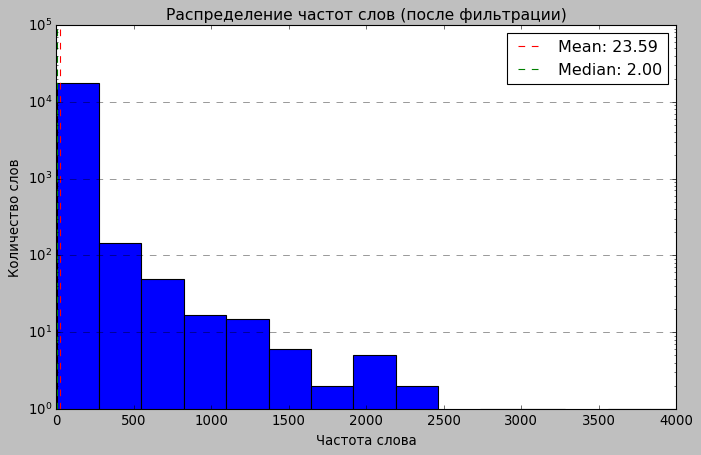

In [53]:
import numpy as np

# Plot
plt.figure(figsize=(10, 6))
plt.hist(freq_values, bins=50, edgecolor="black", color="blue", log=True)

# Statistics
mean_freq = np.mean(freq_values)
median_freq = np.median(freq_values)
plt.axvline(mean_freq, color="red", linestyle="--", label=f"Mean: {mean_freq:.2f}")
plt.axvline(median_freq, color="green", linestyle="--", label=f"Median: {median_freq:.2f}")

# Labels, grid, and limits
plt.title("Распределение частот слов (после фильтрации)", fontsize=14)
plt.xlabel("Частота слова", fontsize=12)
plt.ylabel("Количество слов", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.xlim(0, 4_000)  # Adjust limits if necessary

plt.show()

### Закон Ципфа

Первая часть (левая сторона):
Небольшое число слов с высоким рангом (частотные слова).
Это, скорее всего, служебные слова или высокочастотные термины.
Середина графика:
Умеренно частотные слова.
Они обычно составляют ключевую лексическую часть текста.
Правая часть (хвост):
Большинство слов встречается крайне редко (1–2 раза).
Это могут быть опечатки, уникальные термины или очень редкие слова.

Фильтрация:
Слова с частотой < 5 (правая часть) можно удалить как "шум".
Стоп-слова:
Самые частотные слова (левая часть) могут быть стоп-словами (например, "и", "в").
Фокус на среднечастотные слова:
Слова из середины графика чаще всего несут основную смысловую нагрузку.

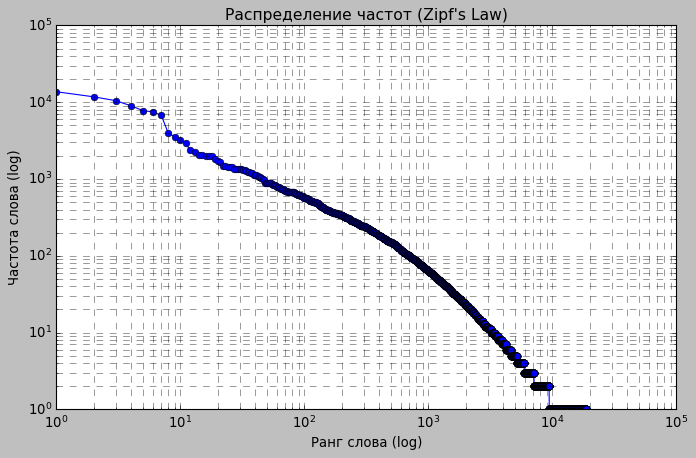

In [54]:
import matplotlib.pyplot as plt

# Ранжирование слов по частотности
word_counts = sorted(counter.values(), reverse=True)

# Логарифмический график
plt.figure(figsize=(10, 6))
plt.loglog(range(1, len(word_counts) + 1), word_counts, marker="o")
plt.title("Распределение частот (Zipf's Law)", fontsize=14)
plt.xlabel("Ранг слова (log)", fontsize=12)
plt.ylabel("Частота слова (log)", fontsize=12)
plt.grid(which="both", linestyle="--", alpha=0.7)
plt.show()

####  График "доля слов" (Cumulative Distribution)

1500 слов - охватывает 82% текстов

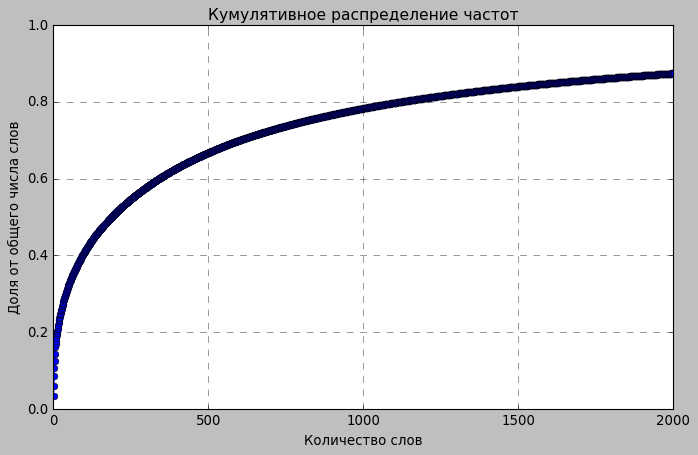

In [57]:
import numpy as np

# Считаем кумулятивную частоту
word_counts = sorted(counter.values(), reverse=True)
cumulative_freq = np.cumsum(word_counts) / sum(word_counts)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_freq) + 1), cumulative_freq, marker="o")
plt.title("Кумулятивное распределение частот", fontsize=14)
plt.xlabel("Количество слов", fontsize=12)
plt.ylabel("Доля от общего числа слов", fontsize=12)
plt.grid(which="both", linestyle="--", alpha=0.7)
plt.xlim(0, 2_000)  # Adjust limits if necessary
plt.show()

### Encoding

In [71]:
df_init["encode_5"] = df_init.normalized_review_text.apply(
    lambda x: [w2id_5.get(w, None) for w in x.split() if w in w2id_5]
)

df_init["encode_10"] = df_init.normalized_review_text.apply(
    lambda x: [w2id_10.get(w, None) for w in x.split() if w in w2id_10]
)

df_init["encode_100"] = df_init.normalized_review_text.apply(
    lambda x: [w2id_100.get(w, None) for w in x.split() if w in w2id_100]
)

df_init["encode_500"] = df_init.normalized_review_text.apply(
    lambda x: [w2id_500.get(w, None) for w in x.split() if w in w2id_500]
)

In [77]:
print("min, mean, max")

min_length = df_init["encode_5"].apply(len).min()
max_length = df_init["encode_5"].apply(len).max()
mean_length = df_init["encode_5"].apply(len).mean()
print(min_length, mean_length, max_length)

min_length = df_init["encode_10"].apply(len).min()
max_length = df_init["encode_10"].apply(len).max()
mean_length = df_init["encode_10"].apply(len).mean()
print(min_length, mean_length, max_length)

min_length = df_init["encode_100"].apply(len).min()
max_length = df_init["encode_100"].apply(len).max()
mean_length = df_init["encode_100"].apply(len).mean()
print(min_length, mean_length, max_length)

min_length = df_init["encode_500"].apply(len).min()
max_length = df_init["encode_500"].apply(len).max()
mean_length = df_init["encode_500"].apply(len).mean()
print(min_length, mean_length, max_length)

min, mean, max
4 57.34467713787085 1493
4 55.76672484002327 1426
4 44.02981384525887 1061
2 26.40997673065736 637


In [84]:
df_init["filtered_norm_text_5"] = df_init.normalized_review_text.apply(
    lambda x: " ".join([w for w in x.split() if w in w2id_5])
)

df_init["filtered_norm_text_10"] = df_init.normalized_review_text.apply(
    lambda x: " ".join([w for w in x.split() if w in w2id_10])
)

df_init["filtered_norm_text_100"] = df_init.normalized_review_text.apply(
    lambda x: " ".join([w for w in x.split() if w in w2id_100])
)

df_init["filtered_norm_text_500"] = df_init.normalized_review_text.apply(
    lambda x: " ".join([w for w in x.split() if w in w2id_500])
)

## TF-IDF

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_init["filtered_norm_text_5"].to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
# Convert sparse matrix to a dense NumPy array
X_dense = X.toarray()
df_init["tfidf_vector_5"] = list(X_dense)
X.shape, type(X)

((6876, 4607), scipy.sparse._csr.csr_matrix)

In [95]:
corpus = df_init["filtered_norm_text_10"].to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
# Convert sparse matrix to a dense NumPy array
X_dense = X.toarray()
df_init["tfidf_vector_10"] = list(X_dense)
X.shape, type(X)

((6876, 3190), scipy.sparse._csr.csr_matrix)

In [96]:
corpus = df_init["filtered_norm_text_100"].to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
# Convert sparse matrix to a dense NumPy array
X_dense = X.toarray()
df_init["tfidf_vector_100"] = list(X_dense)
X.shape, type(X)

((6876, 686), scipy.sparse._csr.csr_matrix)

In [97]:
corpus = df_init["filtered_norm_text_500"].to_list()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
# Convert sparse matrix to a dense NumPy array
X_dense = X.toarray()
df_init["tfidf_vector_500"] = list(X_dense)
X.shape, type(X)

((6876, 119), scipy.sparse._csr.csr_matrix)

### Save-load checkpoint tfidf

In [6]:
# checkpoint tfidf save
# df_init.to_parquet(project_root / "data" / "interim" / "tfidf_check_point.parquet", index=False)
df_init = pd.read_parquet(project_root / "data" / "interim" / "tfidf_check_point.parquet")

##  Take FastText, not Word2Vec 

TBD: Сравнение моделей Word2Vec vs FastText

модели https://rusvectores.org/ru/models/

In [ ]:
import gensim
import gensim.downloader as api


from gensim.models import KeyedVectors


model = KeyedVectors.load("../models/213/model.model")

# Для запуска модели FastText нужен
# gensim@4.3.2  scipy@1.11.4

In [25]:
# Configuration about the model
from pprint import pprint
import json

# Read JSON file
pth_json_model_config = project_root / "models" / "213" / "meta.json"
with open(pth_json_model_config, "r", encoding="utf-8") as file:
    data = json.load(file)

pprint(data, indent=4)

{   'algorithm': {   'command': None,
                     'id': 8,
                     'name': 'fastText Skipgram',
                     'tool': 'Gensim',
                     'url': 'https://github.com/RaRe-Technologies/gensim',
                     'version': '3.8'},
    'contents': [   {'filename': 'model.model', 'format': 'data'},
                    {'filename': 'model.model.vectors.npy', 'format': 'data'},
                    {   'filename': 'model.model.vectors_ngrams.npy',
                        'format': 'data'},
                    {   'filename': 'model.model.vectors_vocab.npy',
                        'format': 'data'},
                    {'filename': 'meta.json', 'format': 'json'}],
    'corpus': [   {   'NER': True,
                      'case preserved': False,
                      'description': 'GeoWAC: Population-balanced Russian '
                                     'Gigaword Corpus',
                      'id': 121,
                      'language': 'rus',
   

In [14]:
model?

Type:            FastTextKeyedVectors
String form:     FastTextKeyedVectors<vector_size=300, 154923 keys>
Length:          154923
File:            c:\users\baksa\appdata\roaming\python\python311\site-packages\gensim\models\fasttext.py
Docstring:       <no docstring>
Class docstring:
Serialize/deserialize objects from disk, by equipping them with the `save()` / `load()` methods.

Warnings
--------
This uses pickle internally (among other techniques), so objects must not contain unpicklable attributes
such as lambda functions etc.
Init docstring: 
Vectors and vocab for :class:`~gensim.models.fasttext.FastText`.

Implements significant parts of the FastText algorithm.  For example,
the :func:`word_vec` calculates vectors for out-of-vocabulary (OOV)
entities.  FastText achieves this by keeping vectors for ngrams:
adding the vectors for the ngrams of an entity yields the vector for the
entity.

Similar to a hashmap, this class keeps a fixed number of buckets, and
maps all ngrams to buckets 

In [16]:
import numpy as np


def get_sentence_embedding(sentence, model):
    words = sentence.split()  # Tokenize sentence
    word_vectors = [model[word] for word in words if word in model]  # Get word vectors
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Mean pooling
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words found


# Apply the function to different columns
df_init["fasttext_vector_5"] = df_init["filtered_norm_text_5"].apply(lambda x: get_sentence_embedding(x, model))
df_init["fasttext_vector_10"] = df_init["filtered_norm_text_10"].apply(lambda x: get_sentence_embedding(x, model))
df_init["fasttext_vector_100"] = df_init["filtered_norm_text_100"].apply(lambda x: get_sentence_embedding(x, model))
df_init["fasttext_vector_500"] = df_init["filtered_norm_text_500"].apply(lambda x: get_sentence_embedding(x, model))

In [12]:
df_init.columns

Index(['review_id', 'review_text', 'normalized_review_text', 'loc_count',
       'org_count', 'misc_count', 'per_count', 'right_parenthesis_cnt',
       'left_parenthesis_cnt', 'point_cnt', 'comma_cnt', 'exlaim_cnt',
       'num_cnt', 'len_in_symbols', 'len_in_words', 'avr_len_words',
       'encode_5', 'encode_10', 'encode_100', 'encode_500',
       'filtered_norm_text_5', 'filtered_norm_text_10',
       'filtered_norm_text_100', 'filtered_norm_text_500', 'tfidf_vector_5',
       'tfidf_vector_10', 'tfidf_vector_100', 'tfidf_vector_500',
       'fasttext_vector_5', 'fasttext_vector_10', 'fasttext_vector_100',
       'fasttext_vector_500'],
      dtype='object')

##  rubert-tiny

https://huggingface.co/cointegrated/rubert-tiny2

In [31]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model.cuda()  # uncomment it if you have a GPU


def embed_bert_cls(text, model, tokenizer):
    # Normalize entity formatting
    replacements = {
        "<loc>": "<локация>",
        "<org>": "<организация>",
        "<num>": "<число>",
        "<per>": "<персона>",
        "<misc>": "<разное>",
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    t = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()


print(embed_bert_cls("привет мир", model, tokenizer).shape)

C:\Users\baksa\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


(312,)


In [32]:
# Apply the function to different columns
df_init["rubert_tiny_vector_5"] = df_init["filtered_norm_text_5"].apply(lambda x: embed_bert_cls(x, model, tokenizer))
df_init["rubert_tiny_vector_10"] = df_init["filtered_norm_text_10"].apply(lambda x: embed_bert_cls(x, model, tokenizer))
df_init["rubert_tiny_vector_100"] = df_init["filtered_norm_text_100"].apply(
    lambda x: embed_bert_cls(x, model, tokenizer)
)
df_init["rubert_tiny_vector_500"] = df_init["filtered_norm_text_500"].apply(
    lambda x: embed_bert_cls(x, model, tokenizer)
)

##  BERT large model (uncased) for Sentence Embeddings in Russian language

https://huggingface.co/ai-forever/sbert_large_nlu_ru

In [33]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")
model.cuda()  # Uncomment if you have a GPU


# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # Get token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Function to get sentence embeddings using SBERT Large
def embed_sentence(text, model, tokenizer):
    # Normalize entity formatting
    replacements = {
        "<loc>": "<локация>",
        "<org>": "<организация>",
        "<num>": "<число>",
        "<per>": "<персона>",
        "<misc>": "<разное>",
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=24)

    # Move inputs to the same device as model
    encoded_input = {k: v.to(model.device) for k, v in encoded_input.items()}

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input["attention_mask"])

    # Normalize the embedding
    sentence_embedding = torch.nn.functional.normalize(sentence_embedding)

    return sentence_embedding[0].cpu().numpy()


# Apply the function to different columns
df_init["sbert_large_vector_5"] = df_init["filtered_norm_text_5"].apply(lambda x: embed_sentence(x, model, tokenizer))
df_init["sbert_large_vector_10"] = df_init["filtered_norm_text_10"].apply(lambda x: embed_sentence(x, model, tokenizer))
df_init["sbert_large_vector_100"] = df_init["filtered_norm_text_100"].apply(
    lambda x: embed_sentence(x, model, tokenizer)
)
df_init["sbert_large_vector_500"] = df_init["filtered_norm_text_500"].apply(
    lambda x: embed_sentence(x, model, tokenizer)
)

## Save final result

In [35]:
df_init.columns

Index(['review_id', 'review_text', 'normalized_review_text', 'loc_count',
       'org_count', 'misc_count', 'per_count', 'right_parenthesis_cnt',
       'left_parenthesis_cnt', 'point_cnt', 'comma_cnt', 'exlaim_cnt',
       'num_cnt', 'len_in_symbols', 'len_in_words', 'avr_len_words',
       'encode_5', 'encode_10', 'encode_100', 'encode_500',
       'filtered_norm_text_5', 'filtered_norm_text_10',
       'filtered_norm_text_100', 'filtered_norm_text_500', 'tfidf_vector_5',
       'tfidf_vector_10', 'tfidf_vector_100', 'tfidf_vector_500',
       'fasttext_vector_5', 'fasttext_vector_10', 'fasttext_vector_100',
       'fasttext_vector_500', 'rubert_tiny_vector_5', 'rubert_tiny_vector_10',
       'rubert_tiny_vector_100', 'rubert_tiny_vector_500',
       'sbert_large_vector_5', 'sbert_large_vector_10',
       'sbert_large_vector_100', 'sbert_large_vector_500'],
      dtype='object')

In [ ]:
# checkpoint tfidf save
file_name = "all_embeddings"
df_init.to_parquet(project_root / "data" / "interim" / f"{file_name}.parquet", index=False)

# The size of the final file is 220mb